**Udemy 7-9. Making Predictions with a Trained NLP Model**

Torch documentation:

https://torchtext.readthedocs.io/en/latest/data.html

In [29]:
import torch
import torch.nn as nn
import torchtext.legacy.data as ttd # previous: import torchtext.data as ttd
import torch.nn.functional as F
from torchtext.vocab import GloVe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [31]:
# This Url doesn't work with pd.read_csv
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

# Note: If a file is downloaded more than once in the same directory -nc can be helpful.
# When -nc is specified, wget refuses to download newer copies of file.

File ‘spam.csv’ already there; not retrieving.



In [32]:
!head spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim 

In [33]:
df = pd.read_csv("spam.csv", encoding="ISO-8859-1")
df.head() # strange behaviour in columns 2, 3, 4

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [34]:
# Drop unnexessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1);
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [35]:
# Rename columns to something better
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [36]:
# Create binary labels
df['b_labels'] = df['labels'].map({'ham':0, 'spam':1}) # df.map(dict)
df2 = df[['data', 'b_labels']]
df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [37]:
df2.to_csv('spam2.csv', index=False)

In [38]:
TEXT = ttd.Field(
    sequential=True, # each value is a sequence of words
    batch_first=True, # Data is of size N x ...
    lower=True, # to lower case the dataset
    tokenize='spacy',
    pad_first=True, # pre-padding instead of post-padding
)

LABEL = ttd.Field(
    sequential=False, # Not a sequential
    use_vocab=False, # we don't do preproceesing on targets to convert vocabs to numbers. They are already digits. If it is True then torch build a vocabulary of word in the dataset.
    is_target=True,
)

In [39]:
dataset = ttd.TabularDataset(
    path='spam2.csv',
    format='csv', # also could be tsv or json
    skip_header=True, # skip the first row
    fields=[('data', TEXT), ('label', LABEL)] # (name_of_the_field_in_csv_file, object_of_corresponding_field)
)

# Note: Fields must be in order that appears in the file

In [40]:
train_dataset, test_dataset = dataset.split() # default split_ratio=0.7

In [41]:
# Internally assign an integer to each token
TEXT.build_vocab(train_dataset)
vocab = TEXT.vocab

In [42]:
# Note:
# itos and stoi are C-style naming
# vocab.stoi['dog'] = 211
# vocab.itos[211] = 'dog'

print(vocab.itos) # returns a list of vocabs 
print(vocab.stoi) # returns a dictionary of vocab and indices

['<unk>', '<pad>', '.', 'i', 'you', 'to', ',', '?', 'a', '!', 'the', '...', 'u', 'and', 'in', 'is', 'me', 'my', 'it', '..', 'for', 'do', 'your', 'have', 'of', 'that', 'call', 'on', '&', 'are', '2', "'s", 'now', ' ', 'so', 'not', 'but', 'or', ';', 'at', 'we', 'get', 'can', "'m", 'just', 'ur', 'if', 'with', ':', 'will', 'be', 'no', "n't", 'this', 'nt', 'how', '4', '*', 'up', 'free', 'go', 'out', 'ok', 'what', 'when', '-', ')', 'from', '/', 'lt;#&gt', 'all', 'got', 'was', 'know', 'like', 'am', 'good', 'then', '"', "'ll", 'he', 'day', 'there', 'come', 'its', 'did', 'only', 'time', 'want', 'text', 'love', 'send', 'going', 'need', 'home', 'see', 'one', 'as', 'back', 'by', 'lor', 'n', 'txt', 'about', 'r', 'she', 'today', 'sorry', 'stop', 'our', 'they', 'mobile', 'still', 'later', 'hi', 'new', 'reply', 'tell', 'please', 'any', 'been', 'take', '_', 'da', 'week', "'", 'think', 'd', 'phone', 'here', 'some', 'where', 'ca', 'pls', 'has', 'her', 'well', 'dear', 'great', 'ì', 'hey', 'wat', 'claim', '

In [43]:
train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset, test_dataset),
    sort_key= lambda x: len(x.data), # A function to sort the texts by length - x is an object of Example class
    batch_sizes=(32, 256), # (batch_size_train, batch_size_test)
    device=device, # Automatically transfer the model to device (GPU)
)

In [44]:
# What is the shape of embedding output
embed = nn.Embedding(num_embeddings=len(vocab), embedding_dim=20).to(device)
for inputs, targets in train_iter:
  print("inputs:", inputs.shape)
  print("targets:", targets.shape)
  out = embed(inputs)
  print("out:", out.shape)
  break

inputs: torch.Size([32, 38])
targets: torch.Size([32])
out: torch.Size([32, 38, 20])


**CNN Arithmetic**

$
H_{out}=
⌊{(H_{in} + 2 × P - D × (K - 1) - 1)/S + 1}⌋
$

D: Dilation

P: Padding

K: Kernel size

S: Stride

`H_out = np.floor((H_in + 2 * padding - dilation*(kernel_size - 1)-1)/stride +1)`

In [45]:
# Define the model
class RNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_outputs):
    super().__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.K = n_outputs

    # Embedding
    self.embed = nn.Embedding(self.V, self.D) # N x T -> N x T x D


    # Convolution layers
    # Note: in Conv1D we have
    # input (batch size, number of channels, length of signal sequence)  # N x D x T 
    # output (batch size, new number of channels, new length of signal sequence)  # N x D2 x T2
    
    self.conv1 = nn.Conv1d(in_channels=self.D, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool1d(kernel_size=2)
    self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool1d(kernel_size=2)
    self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

    # FC layer
    self.fc = nn.Linear(in_features=128, out_features=self.K)
    
  def forward(self, X):
    # embed layer | in: N x T | out: N x T x D
    out = self.embed(X)
    
    # rearrange the data
    out = out.permute(0,2,1) # in: N x T x D | out: N x D x T

    # cnn layer
    out = self.conv1(out) # N x D x T -> N x D x T2  (same)
    out = F.relu(out)
    out = self.pool1(out) # N x D x T2 -> N x D/2 x T2
    out = self.conv2(out) # N x D/2 x T2 -> N x D/2 x T3
    out = F.relu(out)
    out = self.pool2(out) # N x D/2 x T3 -> N x D/4 x T3
    out = self.conv3(out) # N x D/4 x T3 -> N x D/4 x T4
    out = F.relu(out)

    # rearrange the data back
    out = out.permute(0,2,1) # in: N x D x T | out: N x T x D

    # max pool | in: N x T x D | out: N x D
    out, _ = torch.max(out, axis=1)

    # dense layer | in: N x D | out: N x K
    out = self.fc(out)
    return out

In [46]:
model = RNN(n_vocab=len(vocab), embed_dim=1 ,n_outputs=1)
model.to(device)

RNN(
  (embed): Embedding(7788, 1)
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [47]:
# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [48]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_iter:
      targets = targets.view(-1,1).float() # Miner tweak: convert target from (N,) to (N,1) - 2D Array

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and Optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    
    # get the train_loss and test_loss
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_iter:
      targets = targets.view(-1,1).float() # Miner tweak: conver target from (N,) to (N,1) - 2D Array
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    if (it + 1) % 1 == 0:
      print(f"Epoch {it+1}/{epochs}, Train_loss: {train_losses[it]:.4f}, Test_loss: {test_losses[it]:.4f}, Duration: {dt}")
  return train_losses, test_losses

In [67]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs=20)

Epoch 1/20, Train_loss: 0.0784, Test_loss: 0.1592, Duration: 0:00:01.247878
Epoch 2/20, Train_loss: 0.0739, Test_loss: 0.1902, Duration: 0:00:01.308001
Epoch 3/20, Train_loss: 0.0605, Test_loss: 0.1896, Duration: 0:00:01.260279
Epoch 4/20, Train_loss: 0.0649, Test_loss: 0.1491, Duration: 0:00:01.194313
Epoch 5/20, Train_loss: 0.0597, Test_loss: 0.1624, Duration: 0:00:01.276358
Epoch 6/20, Train_loss: 0.0549, Test_loss: 0.1536, Duration: 0:00:01.252639
Epoch 7/20, Train_loss: 0.0500, Test_loss: 0.1512, Duration: 0:00:01.190010
Epoch 8/20, Train_loss: 0.0460, Test_loss: 0.1367, Duration: 0:00:01.244259
Epoch 9/20, Train_loss: 0.0402, Test_loss: 0.1407, Duration: 0:00:01.233465
Epoch 10/20, Train_loss: 0.0402, Test_loss: 0.1429, Duration: 0:00:01.247299
Epoch 11/20, Train_loss: 0.0352, Test_loss: 0.1437, Duration: 0:00:01.186897
Epoch 12/20, Train_loss: 0.0400, Test_loss: 0.1434, Duration: 0:00:01.136699
Epoch 13/20, Train_loss: 0.0336, Test_loss: 0.1408, Duration: 0:00:01.172984
Epoch 14

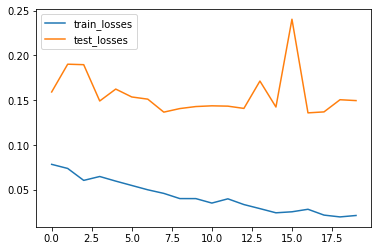

In [68]:
plt.plot(train_losses, label="train_losses")
plt.plot(test_losses, label="test_losses")
plt.legend()
plt.show()

In [69]:
# Accuracy
n_correct = 0
n_total = 0
for inputs, targets in train_iter:
  targets = targets.view(-1,1).float()
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct/n_total


# test accuracy
n_correct = 0
n_total = 0
for inputs, targets in test_iter:
  targets = targets.view(-1,1).float()
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9954, Test acc: 0.9599


In [52]:
# The rate of spam documents
df[df['labels'] == 'spam'].size/df.size

0.13406317300789664

In [70]:
#plot Confusion Matrix 
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='confusion_matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'
  """

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Confusion Matrix without Normalization")
  
  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             ha='center', # horizontalalignment
             va='center', # verticalalignment
             color="white" if cm[i,j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()

Confusion Matrix without Normalization
[[1422   18]
 [  49  183]]


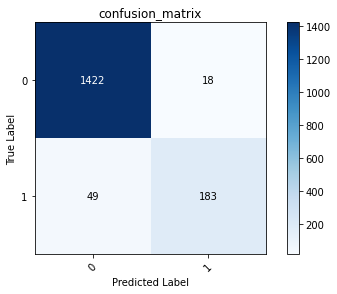

In [73]:
# plot confusion matrix for test dataset
p_test = []
y_test = []

for inputs, targets in test_iter:
  targets = targets.view(-1,1).float()

  outputs = model(inputs)
  
  # Get Predictions
  predictions = list((outputs > 0).cpu().numpy())

  # Store Predictions
  p_test += predictions
  y_test += list(targets.cpu().numpy())

p_test = np.array(p_test)
y_test = np.array(y_test)

test_acc = np.mean(p_test == y_test)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, [0, 1])

In [77]:
df[df.labels=="spam"].sample(3)

,labels,data,b_labels
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1
